In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (20, 8)

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [4]:
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNet

In [5]:
img_size = 150
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1/255.,
                                   rotation_range = 30,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)  # this is for normalization, basically to shorten the range
val_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory('/kaggle/input/dogs-cats-images/dataset/training_set',
                                                   target_size=(img_size, img_size),
                                                   batch_size=batch_size,
                                                   shuffle=True,  # shuffle the images in every iteration
                                                   class_mode='binary')

val_generator = val_datagen.flow_from_directory('/kaggle/input/dogs-cats-images/dataset/test_set',
                                                   target_size=(img_size, img_size),
                                                   batch_size=batch_size,
                                                   shuffle=False,
                                                   class_mode='binary')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


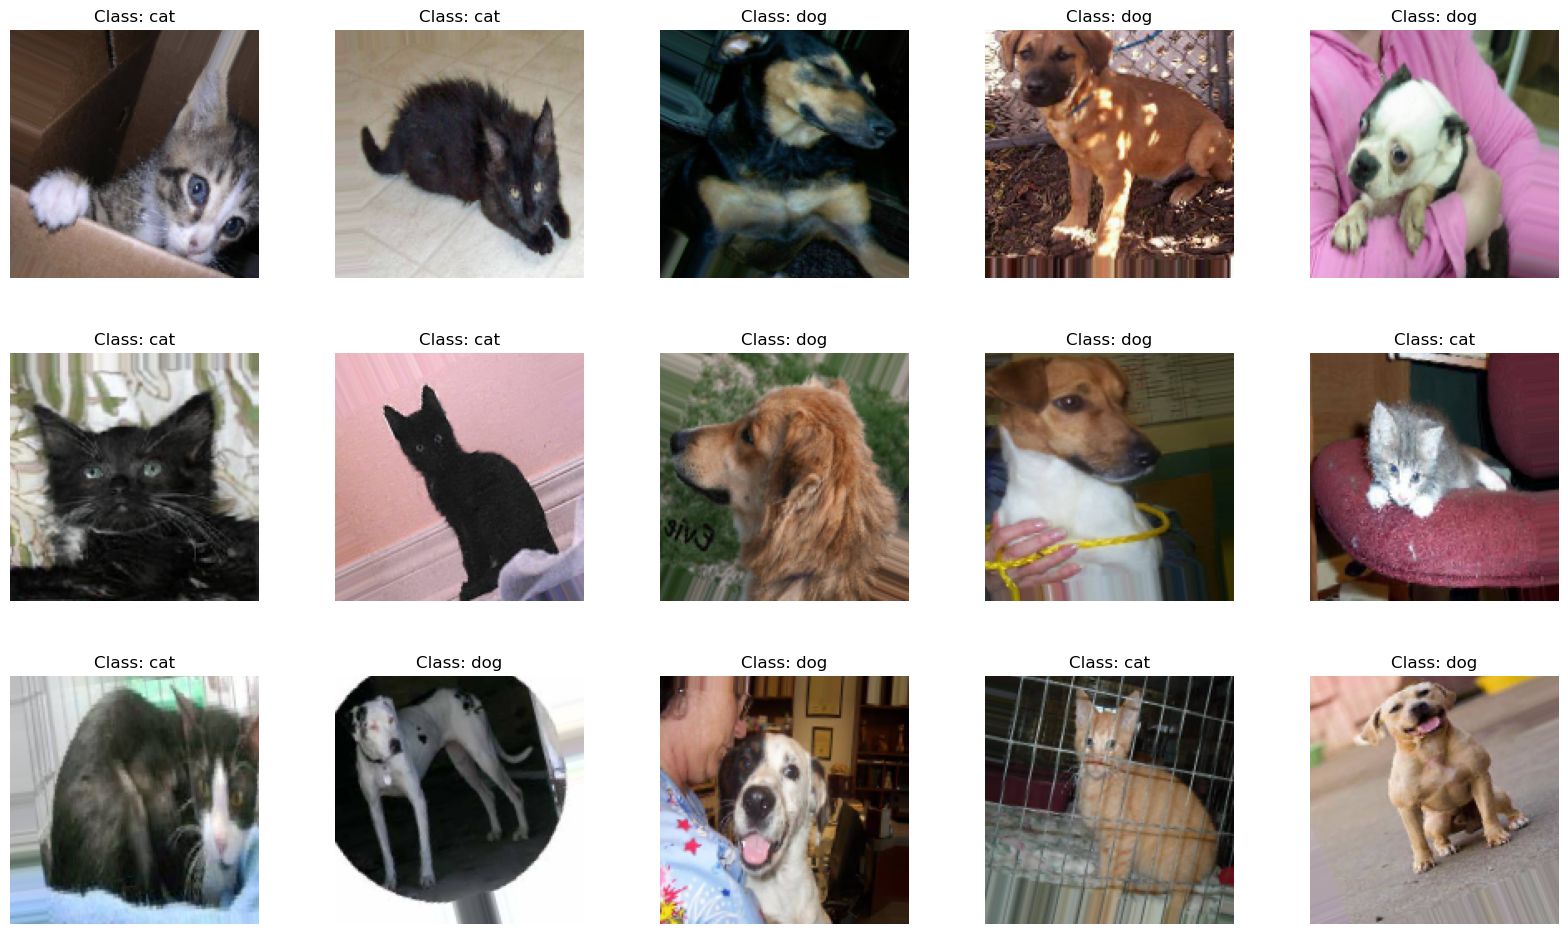

In [6]:
labels = ['cat','dog']
samples = train_generator.__next__()
images = samples[0]
target = samples[1]

plt.figure(figsize = (20 , 20))
for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f"Class: {labels[int(target[i])]}")
    plt.axis('off')

In [7]:
img_size = 224
base_model = VGG16(include_top = False,   # include_top is to include the classifier layer; whether to include the 3 fully-connected layers at the top of the network
                  weights = 'imagenet',
                  input_shape = (img_size, img_size, 3))

58889256/58889256 [==============================] - 3s 0us/step


In [8]:
base_model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [10]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [12]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer

In [13]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [15]:
model_name = 'model.h5'
checkpoint = ModelCheckpoint(model_name,
                            monitor = 'val_loss',
                            mode = 'min',
                            save_best_only = True,
                            verbose = 1)

earlystopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 1, restore_best_weights = True)


In [16]:
last_output = base_model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
model = Model(inputs = base_model.inputs, outputs = outputs)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])


In [17]:
history = model.fit(train_generator,
                   epochs = 3,
                   validation_data = val_generator,
                   callbacks = [checkpoint, earlystopping])


Epoch 1/3
250/250 [==============================] - ETA: 0s - loss: 0.2752 - accuracy: 0.8792
Epoch 1: val_loss improved from inf to 0.15622, saving model to model.h5
250/250 [==============================] - 116s 428ms/step - loss: 0.2752 - accuracy: 0.8792 - val_loss: 0.1562 - val_accuracy: 0.9380
Epoch 2/3
250/250 [==============================] - ETA: 0s - loss: 0.1723 - accuracy: 0.9295
Epoch 2: val_loss improved from 0.15622 to 0.13262, saving model to model.h5
250/250 [==============================] - 70s 281ms/step - loss: 0.1723 - accuracy: 0.9295 - val_loss: 0.1326 - val_accuracy: 0.9495
Epoch 3/3
250/250 [==============================] - ETA: 0s - loss: 0.1384 - accuracy: 0.9451
Epoch 3: val_loss did not improve from 0.13262
250/250 [==============================] - 69s 275ms/step - loss: 0.1384 - accuracy: 0.9451 - val_loss: 0.1339 - val_accuracy: 0.9440


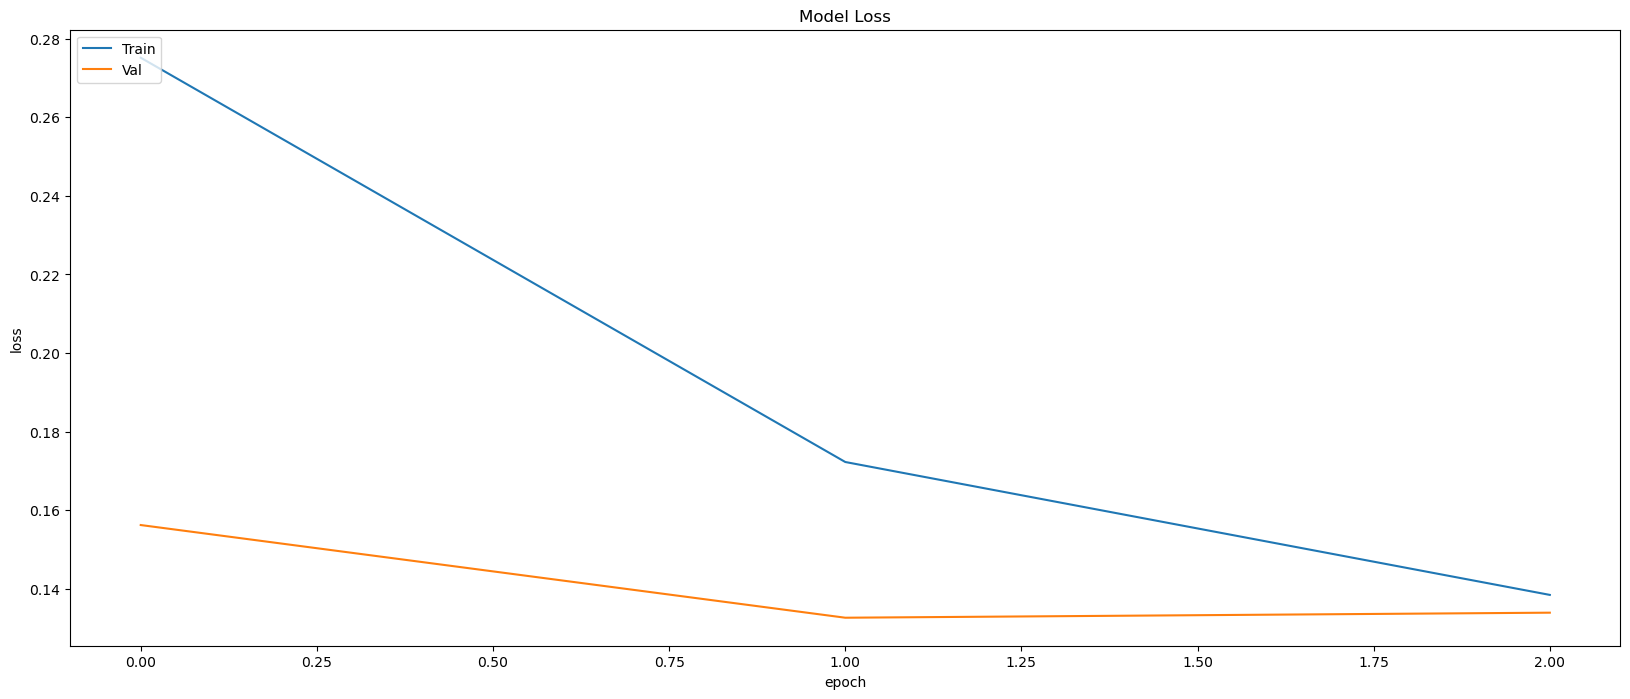

In [18]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

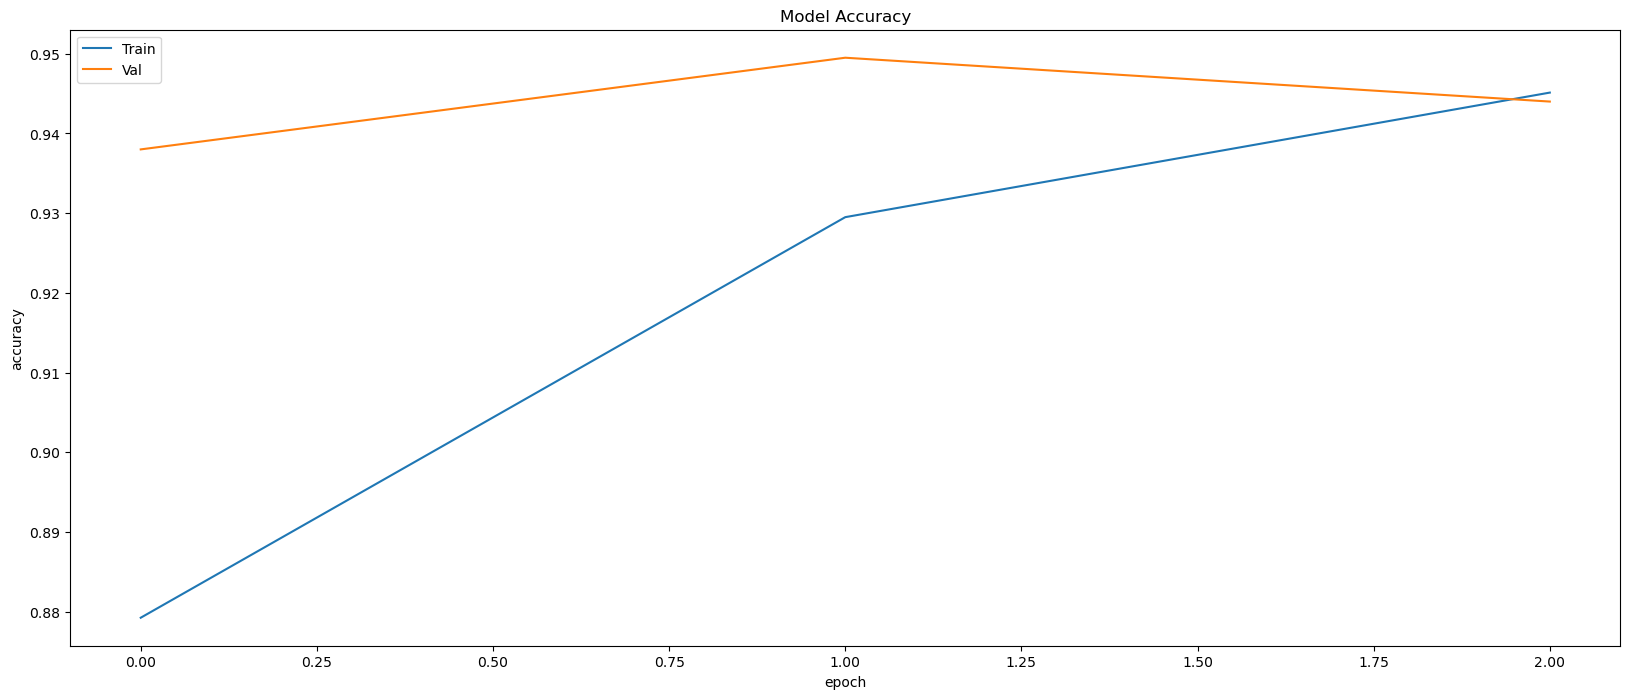

In [19]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [21]:
model = tf.keras.models.load_model('/kaggle/working/model.h5')

In [23]:
y_test = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_probs = y_pred.copy()

63/63 [==============================] - 7s 105ms/step


In [24]:
y_pred[y_pred>0.5] = 1
y_pred[y_pred<0.5] = 0

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

In [26]:
print(classification_report(y_test,y_pred,target_names = ['cats','dogs']))

              precision    recall  f1-score   support

        cats       0.94      0.96      0.95      1000
        dogs       0.96      0.94      0.95      1000

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



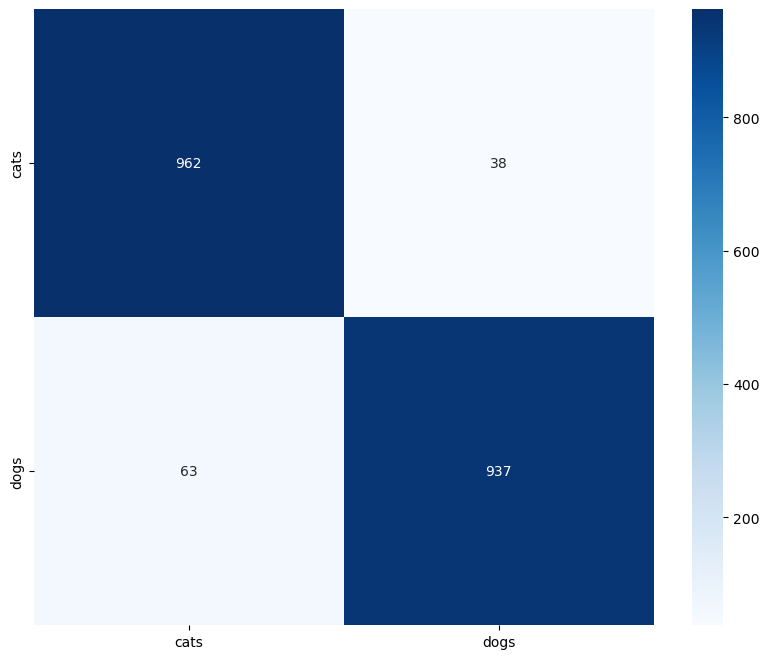

In [27]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.3g',xticklabels=['cats','dogs'],
            yticklabels=['cats','dogs'],cmap='Blues')
plt.show()

In [28]:
from sklearn.metrics import roc_curve, roc_auc_score

In [29]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = roc_auc_score(y_test, y_pred_probs)

In [30]:
roc_auc

0.9896809999999999

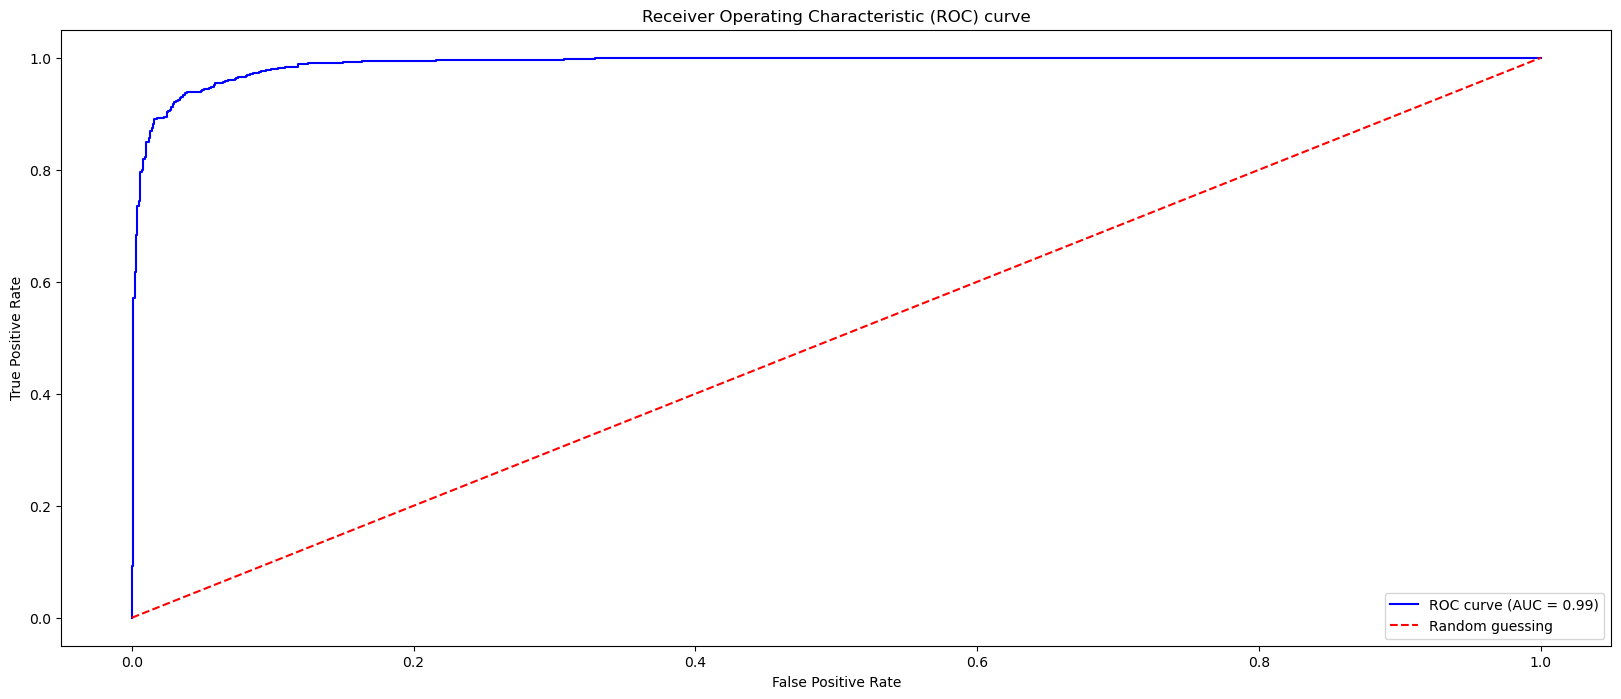

In [31]:
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend(loc='lower right')
plt.show()